# Big Data Coursework - Questions

## Data Processing and Machine Learning in the Cloud

This is the **INM432 Big Data coursework 2024**.
This coursework contains extended elements of **theory** and **practice**, mainly around parallelisation of tasks withSpark and a bit about parallel training using TensorFlow.   

## Code and Report

Your tasks parallelization of tasks in PySpark, extension, evaluation, and theoretical reflection.
Please complete and submit the **coding tasks** in a copy of **this notebook**.
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that **your code contains comments** on its **stucture** and explanations of its **purpose**.

Provide also a **report** with the **textual answers in a separate document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google provides, but take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis.



## Submission

Download and submit **your version of this notebook** as an **.ipynb** file and also submit a **shareable link** to your notebook on Colab in your report (created with the Colab 'Share' function) (**and don’t change the online version after submission**).

Further, provide your **report as a PDF document**. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  


Please also submit **a PDF of your Jupyter notebook**.

## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras.
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner.
The course is based on Tensorflow for data processing and MachineLearning.
Tensorflow's data processing approach is somewhat similar to that of Spark, but you don't need to study Tensorflow, just make sure you understand the high-level structure.  
What we will do here is **parallelising** **pre-processing**, and **measuring** performance, and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**.

This coursework contains **3 sections**.

### Section 0

This section just contains some necessary code for setting up the environment. It has no tasks for you (but do read the code and comments).

### Section 1
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes).
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like.

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package.
There is no task for you here, but you will need to re-use some of this code later.

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc.
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud.

### Section 2
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

### Section 3

This section is about the theoretical discussion, based on one paper, in **Task 3**. The answers should be given in the PDF report.

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis.

The **tasks** are **mostly independent** of each other. The later tasks can mostly be addressed without needing the solution to the earlier ones.  

# Section 0: Set-up

As usual, you need to run the **imports and authentication every time you work with this notebook**. Use the **local Spark** installation for development before you send jobs to the cloud.

Read through this section once and **fill in the project ID the first time**, then you can just step straight throught this at the beginning of each session - except for the two authentication cells.

### Imports

We import some **packages that will be needed throughout**.
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below.


In [1]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.15.0


### Cloud and Drive authentication

This is for **authenticating with with GCS Google Drive**, so that we can create and use our own buckets and access Dataproc and AI-Platform.

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW` thay you can use for this work.
Then we'll set up the cloud environment, including a storage bucket.

In [2]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [3]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to **create a new Google Cloud project** for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also **enable billing** and the **Compute, Storage and Dataproc** APIs like we did during the labs.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit.
This way we don't have to specify this information every time we access the cloud.  

In [4]:
PROJECT = 'earnest-crow-421721'  ### USE YOUR GOOGLE CLOUD PROJECT ID HERE. ###
!gcloud config set project $PROJECT
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
region = us-central1
[core]
account = SiddhiBhosale00@gmail.com
project = earnest-crow-421721
[dataproc]
region = us-central1

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**.
If the bucket exists you will see a "ServiceException: 409 ...", which does not cause any problems.
**You must create your own bucket to have write access.**

In [5]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://earnest-crow-421721-storage/...
ServiceException: 409 A Cloud Storage bucket named 'earnest-crow-421721-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [9]:
#@title Utility functions for image display **[RUN THIS TO ACTIVATE]** { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


### Install Spark locally for quick testing

You can use the cell below to **install Spark locally on this Colab VM** (like in the labs), to do quicker small-scale interactive testing. Using Spark in the cloud with **Dataproc is still required for the final version**.


In [10]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big_Data/data/spark/spark-3.5.0-bin-hadoop3.tgz" # unpack

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
3.5.0


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning.
We first look at a ready-made solution using Tensorflow and then we build a implement the same process with Spark.
The tasks are about **parallelisation** and **analysis** the performance of the cloud implementations.

## 1.1 Getting started

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

**This code is using the TensorFlow** `tf.data` package, which supports map functions, similar to Spark. Your **task** will be to **re-implement the same approach in Spark**.  


We start by **setting some variables for the *Flowers* dataset**.

In [11]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset.
**TensorFlow** has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we cannont deal with parts of images).

In [12]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))


GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed).
Below are **map functions** for these steps.
You **don't need to study** the **internals of these functions** in detail.

In [29]:
def decoding_jpeg(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resizing_and_cropping_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def optimizing_image_encoding(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

With `tf.data`, we can apply decoding and resizing as map functions.

In [30]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dsetDecoded = dsetFiles.map(decoding_jpeg)
dsetResized = dsetDecoded.map(resizing_and_cropping_image)

We can also look at some images using the image display function defined above (the one with the hidden code).

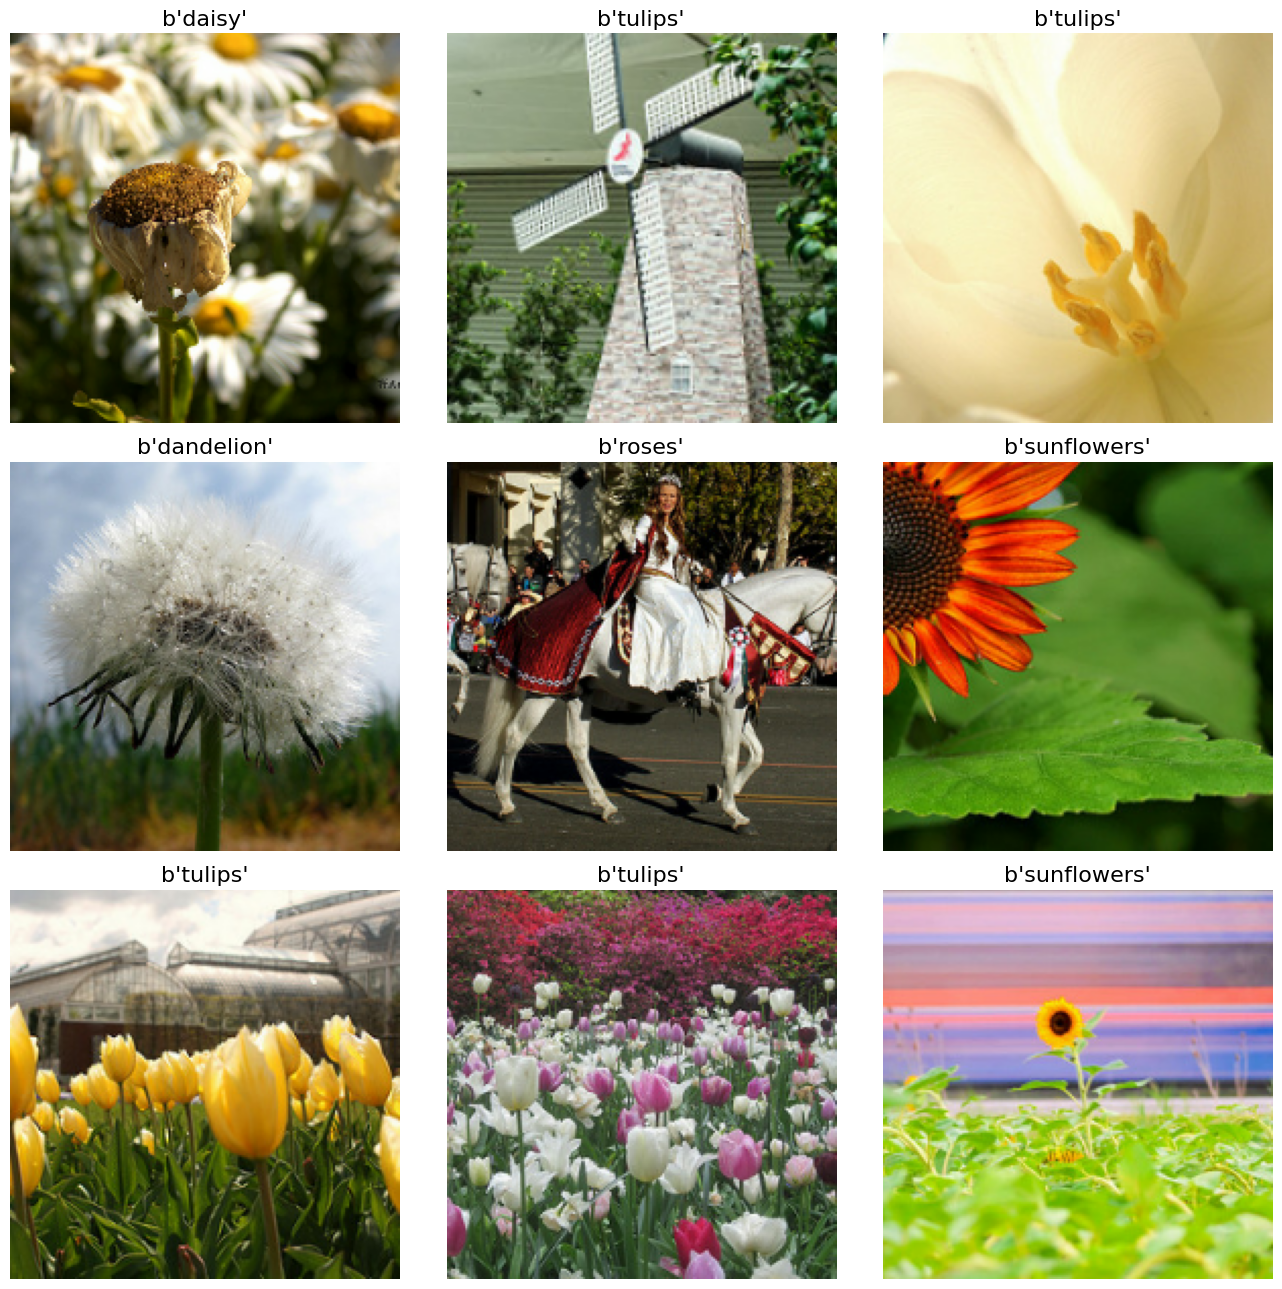

In [31]:
display_9_images_from_dataset(dsetResized)

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [32]:
### CODING TASK ###
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['roses', 'tulips', 'dandelion', 'tulips', 'sunflowers', 'tulips', 'tulips', 'daisy', 'dandelion', 'daisy'])
Image batch shape (10, 192, 192, 3), ['roses', 'sunflowers', 'roses', 'roses', 'roses', 'sunflowers', 'dandelion', 'sunflowers', 'sunflowers', 'daisy'])
Image batch shape (10, 192, 192, 3), ['daisy', 'daisy', 'roses', 'sunflowers', 'dandelion', 'roses', 'daisy', 'daisy', 'dandelion', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['tulips', 'sunflowers', 'roses', 'sunflowers', 'sunflowers', 'roses', 'dandelion', 'tulips', 'tulips', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['daisy', 'roses', 'daisy', 'dandelion', 'sunflowers', 'tulips', 'daisy', 'roses', 'dandelion', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['tulips', 'tulips', 'dandelion', 'sunflowers', 'dandelion', 'roses', 'roses', 'dandelion', 'tulips', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['tulips', 'roses', 'sunflowers', 'sunflowers', 'daisy', 'tuli

## 1.2 Improving Speed

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size.
This **costs some CPU time** upfront, but **saves network and disk bandwith**, especially when the data are **read multiple times**.


In [33]:
### CODING TASK ###
# This is a quick test to get an idea how long recompressions takes.
dataset4 = dsetResized.map(optimizing_image_encoding)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10,), ['dandelion', 'sunflowers', 'tulips', 'sunflowers', 'daisy', 'daisy', 'daisy', 'dandelion', 'dandelion', 'roses'])
Image batch shape (10,), ['tulips', 'daisy', 'daisy', 'daisy', 'dandelion', 'dandelion', 'sunflowers', 'dandelion', 'sunflowers', 'tulips'])
Image batch shape (10,), ['tulips', 'dandelion', 'daisy', 'roses', 'sunflowers', 'sunflowers', 'dandelion', 'tulips', 'roses', 'roses'])
Image batch shape (10,), ['roses', 'sunflowers', 'sunflowers', 'tulips', 'dandelion', 'sunflowers', 'sunflowers', 'daisy', 'sunflowers', 'roses'])
Image batch shape (10,), ['roses', 'sunflowers', 'daisy', 'daisy', 'dandelion', 'roses', 'tulips', 'dandelion', 'dandelion', 'tulips'])
Image batch shape (10,), ['tulips', 'sunflowers', 'daisy', 'sunflowers', 'daisy', 'sunflowers', 'tulips', 'sunflowers', 'roses', 'daisy'])
Image batch shape (10,), ['tulips', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'dandelion', 'tulips', 'dandelion', 'roses', 'dandelion'])
Image batch shap

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains.
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used.
First we need to **define a location** where we want to put the file.

In [34]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket.

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later (but there is no need to study it in detail).

There is a **ready-made pre-processed data** versions available here:
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for testing.

In [35]:
### CODING TASK ###
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size): # write the images to files.
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN)
    dataset1 = filenames.map(extracting_jpeg_and_label)
    dataset2 = dataset1.map(resizing_and_cropping_image)
    dataset3 = dataset2.map(optimizing_image_encoding)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i] #
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

Writing TFRecords
Wrote file gs://earnest-crow-421721-storage/tfrecords-jpeg-192x192-2/flowers00-230.tfrec containing 230 records
Wrote file gs://earnest-crow-421721-storage/tfrecords-jpeg-192x192-2/flowers01-230.tfrec containing 230 records
Wrote file gs://earnest-crow-421721-storage/tfrecords-jpeg-192x192-2/flowers02-230.tfrec containing 230 records
Wrote file gs://earnest-crow-421721-storage/tfrecords-jpeg-192x192-2/flowers03-230.tfrec containing 230 records
Wrote file gs://earnest-crow-421721-storage/tfrecords-jpeg-192x192-2/flowers04-230.tfrec containing 230 records
Wrote file gs://earnest-crow-421721-storage/tfrecords-jpeg-192x192-2/flowers05-230.tfrec containing 230 records
Wrote file gs://earnest-crow-421721-storage/tfrecords-jpeg-192x192-2/flowers06-230.tfrec containing 230 records
Wrote file gs://earnest-crow-421721-storage/tfrecords-jpeg-192x192-2/flowers07-230.tfrec containing 230 records
Wrote file gs://earnest-crow-421721-storage/tfrecords-jpeg-192x192-2/flowers08-230.tfr

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [36]:
#GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**.

In [37]:
### CODING TASK ###
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['0', '2', '0', '1', '4', '4', '3', '1', '4', '3'])
Image batch shape (10, 192, 192, 3), ['3', '1', '4', '0', '4', '3', '1', '3', '1', '0'])
Image batch shape (10, 192, 192, 3), ['4', '3', '0', '0', '2', '4', '4', '1', '3', '1'])
Image batch shape (10, 192, 192, 3), ['1', '2', '2', '4', '3', '4', '4', '1', '3', '1'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '3', '4', '4', '1', '4', '4', '1'])
Image batch shape (10, 192, 192, 3), ['1', '4', '3', '4', '1', '0', '4', '2', '4', '2'])
Image batch shape (10, 192, 192, 3), ['1', '1', '3', '0', '0', '4', '4', '3', '1', '2'])
Image batch shape (10, 192, 192, 3), ['3', '2', '1', '0', '2', '2', '2', '4', '0', '1'])
Image batch shape (10, 192, 192, 3), ['0', '2', '4', '4', '4', '2', '3', '0', '1', '3'])
Image batch shape (10, 192, 192, 3), ['4', '3', '0', '1', '3', '3', '4', '3', '1', '4'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

## Task 1: Write TFRecord files to the cloud with Spark (40%)

Since recompressing and repackaging is very effective, we would like to be able to do it inparallel for large datasets.
This is a relatively straightforward case of **parallelisation**.
We will **use Spark to implement** the same process as above, but in parallel.

### 1a)	Create the script (14%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**.

You need to:

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression functions **to Spark** (only one argument). (3%)

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (3%)

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests. (1%)

iv) Then **use the functions from above** to write the TFRecord files. (3%)

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function.
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files. (4%)


In [ ]:
# Defining necessary libraries
import os
import numpy as np
import tensorflow as tf
import pyspark

# File glob pattern for input files
input_glob_pattern = 'gs://flowers-public/*/*.jpg'
# Project and storage bucket IDs
project_id = 'earnest-crow-421721'
storage_bucket = 'earnest-crow-421721-storage'
# Output path for TFRecord files
output_path = storage_bucket + '/tfrecords-jpeg-192x192-2/flowers'
# Number of partitions for RDD
num_partitions = 16
# Target image size
target_size = [192, 192]
# Labels for the data
data_labels = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

# i) Adapting the resizing and recompression functions to spark

def extracting_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resizing_and_cropping_image(image_label):
    image, label2 = image_label
    width = tf.shape(image)[0]
    height = tf.shape(image)[1]
    twidth = TARGET_SIZE[1]
    theight = TARGET_SIZE[0]
    resizecrit = (width * theight) / (height * tweight)
    image = tf.cond(resizecrit < 1,
                    lambda: tf.image.resize(image, [width*twidth/width, height*twidth/width]), # if true
                    lambda: tf.image.resize(image, [width*theight/height, height*theight/height])  # if false
                    )
    newwidth = tf.shape(image)[0]
    newheight = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (newwidth - twidth) // 2, (newheight - theight) // 2, twidth, theight)
    return image, label2

def optimizing_image_encoding(image_label):
    image, label2 = image_label
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return (image, class_name)

# ii) & iii) Replacing TensorFlow Dataset objects with RDDs AND Sampling RDDs
file_paths = tf.io.gfile.glob(input_glob_pattern)
spark_ctx = pyspark.SparkContext.getOrCreate()
image_files_rdd = spark_ctx.parallelize(file_paths)
sampling_files_rdd = image_files_rdd.sample(False, 0.02)
filesrdd = spark_ctx.parallelize(file_paths)
decoded_images_rdd = image_files_rdd.map(extracting_jpeg_and_label)
resized_images_rdd = decoded_images_rdd.map(resizing_and_cropping_image)
recompressed_images_rdd = resized_images_rdd.map(optimizing_image_encoding)

# iv) Writing TFRecords files using the functions above

def making_tfrecord(tf_writer, image_data, label_data):
    class_index = np.argmax(np.array(CLASSES) == label_data)
    example_features = {
        "image": _bytestring_feature([image_data]),
        "class": _int_feature([class_index])
    }
    return tf.train.Example(features=tf.train.Features(feature=example_features))

print("Writing TFRecord files")

# v) writing to the TFRecord files in a function

def writing_tfrecord_files(partition_index, partition_data):
    output_file_name = OUTPUT_PATH + "{}.tfrec".format(partition_index)
    with tf.io.TFRecordWriter(output_file_name) as tf_writer:
        for img, label in partition_data:
            tfrecord_ex = making_tfrecord(tf_writer, img.numpy(), label.numpy())
            tf_writer.write(tfrecord_exe.SerializeToString())
    return [output_file_name]

final_rdd = recompressed_images_rdd.repartition(num_partitions)
resulting_filenames_rdd = final_rdd.mapPartitionsWithIndex(writing_tfrecord_files)




Writing TFRecord files


### 1b)	Testing (3%)

i) Read from the TFRecord Dataset, using `load_dataset` and `display_9_images_from_dataset` to test.


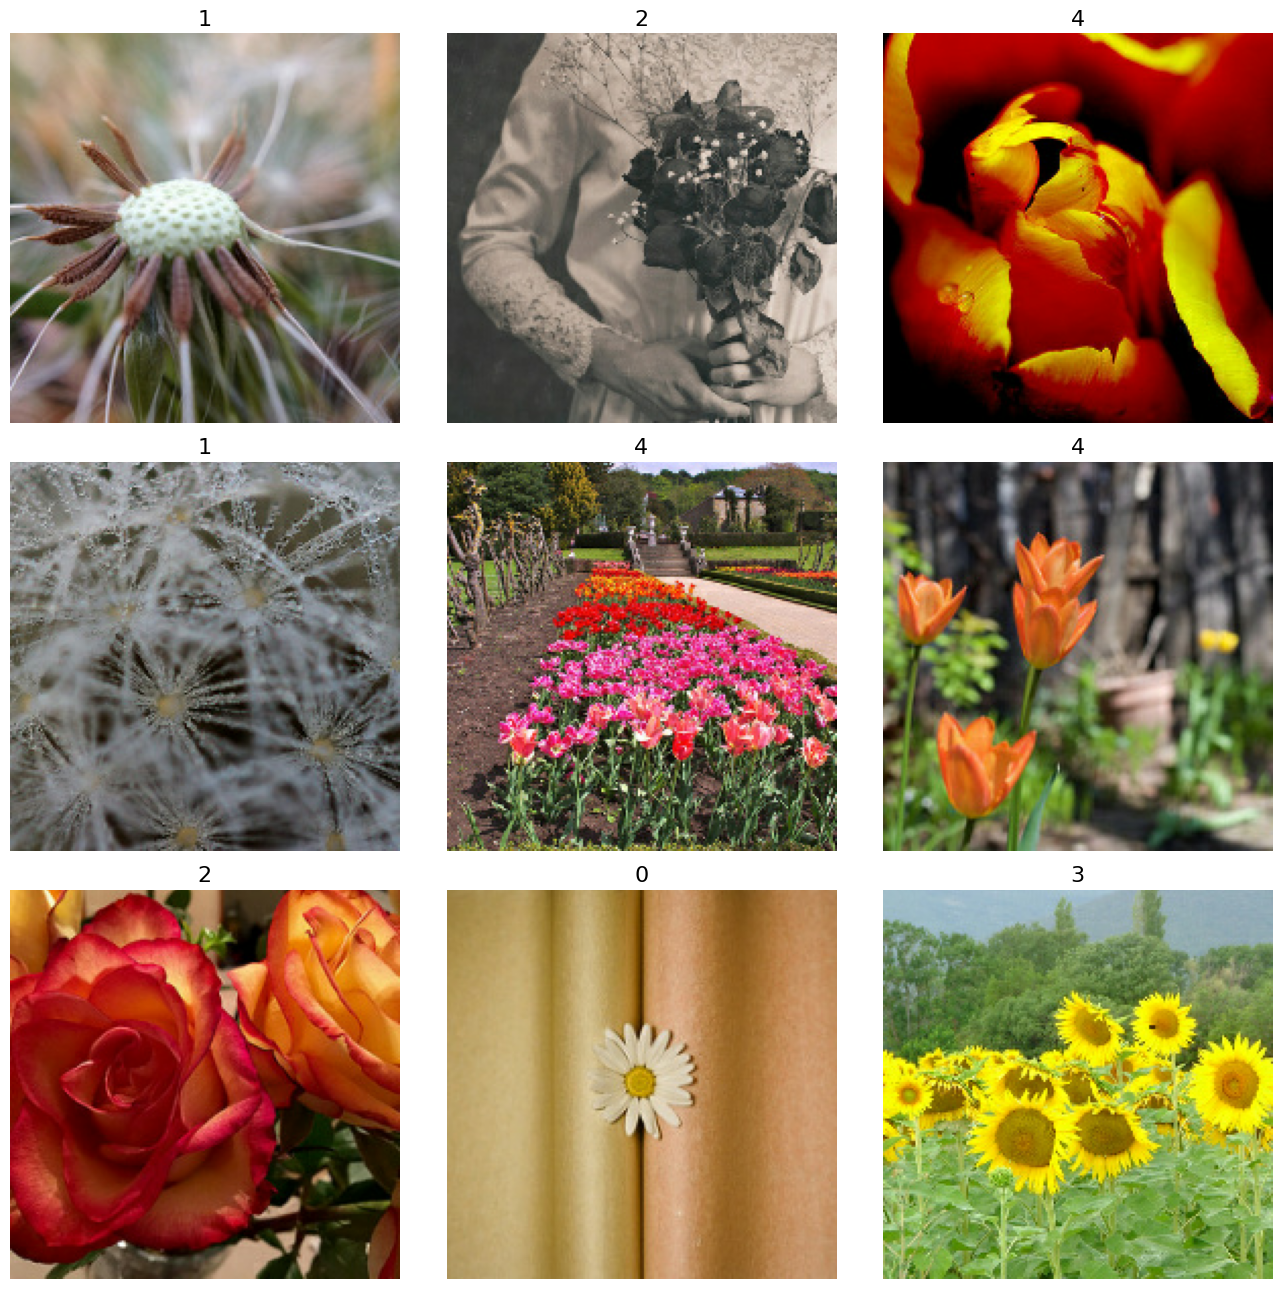

In [ ]:
### CODING TASK ###

# Executing the workflow
file_paths = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
decodeddataset = load_dataset(file_paths)
display_9_images_from_dataset(decodeddataset)


ii) Write your code above into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run the file  locally in Spark.



In [ ]:
### CODING TASK ###
%%writefile spark_write_tfrec.py

# Defining necessary libraries
import os
import numpy as np
import tensorflow as tf
import pyspark

# File glob pattern for input files
input_glob_pattern = 'gs://flowers-public/*/*.jpg'
# Project and storage bucket IDs
project_id = 'earnest-crow-421721'
storage_bucket = 'earnest-crow-421721-storage'
# Output path for TFRecord files
output_path = storage_bucket + '/tfrecords-jpeg-192x192-2/flowers'
# Number of partitions for RDD
num_partitions = 16
# Target image size
target_size = [192, 192]
# Labels for the data
data_labels = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

# i) Adapting the resizing and recompression functions to spark

def extracting_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resizing_and_cropping_image(image_label):
    image, label2 = image_label
    width = tf.shape(image)[0]
    height = tf.shape(image)[1]
    twidth = TARGET_SIZE[1]
    theight = TARGET_SIZE[0]
    resizecrit = (width * theight) / (height * tweight)
    image = tf.cond(resizecrit < 1,
                    lambda: tf.image.resize(image, [width*twidth/width, height*twidth/width]), # if true
                    lambda: tf.image.resize(image, [width*theight/height, height*theight/height])  # if false
                    )
    newwidth = tf.shape(image)[0]
    newheight = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (newwidth - twidth) // 2, (newheight - theight) // 2, twidth, theight)
    return image, label2

def optimizing_image_encoding(image_label):
    image, label2 = image_label
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return (image, class_name)

# ii) & iii) Replacing TensorFlow Dataset objects with RDDs AND Sampling RDDs
file_paths = tf.io.gfile.glob(input_glob_pattern)
spark_ctx = pyspark.SparkContext.getOrCreate()

##Task 1D##
filesrdd = spark_ctx.parallelize(file_paths,16)

image_files_rdd = spark_ctx.parallelize(file_paths,16)
sampling_files_rdd = image_files_rdd.sample(False, 0.02)
decoded_images_rdd = image_files_rdd.map(extracting_jpeg_and_label)
resized_images_rdd = decoded_images_rdd.map(resizing_and_cropping_image)
recompressed_images_rdd = resized_images_rdd.map(optimizing_image_encoding)

# iv) Writing TFRecords files using the functions above

def making_tfrecord(tf_writer, image_data, label_data):
    class_index = np.argmax(np.array(CLASSES) == label_data)
    example_features = {
        "image": _bytestring_feature([image_data]),
        "class": _int_feature([class_index])
    }
    return tf.train.Example(features=tf.train.Features(feature=example_features))

print("Writing TFRecord files")

# v) writing to the TFRecord files in a function

def writing_tfrecord_files(partition_index, partition_data):
    output_file_name = OUTPUT_PATH + "{}.tfrec".format(partition_index)
    with tf.io.TFRecordWriter(output_file_name) as tf_writer:
        for img, label in partition_data:
            tfrecord_ex = making_tfrecord(tf_writer, img.numpy(), label.numpy())
            tf_writer.write(tfrecord_exe.SerializeToString())
    return [output_file_name]

final_rdd = recompressed_images_rdd.repartition(num_partitions)
resulting_filenames_rdd = final_rdd.mapPartitionsWithIndex(writing_tfrecord_files)

Overwriting spark_write_tfrec.py


### 1c) Set up a cluster and run the script. (6%)

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs.

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install).
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`.

Note: consider using `PIP_PACKAGES="tensorflow numpy"` or `PIP_PACKAGES=tensorflow` in case an older version of tensorflow is causing issues.

When the cluster is running, run your script to check that it works and keep the output cell output. (3%)


In [ ]:
### CODING TASK ###

# Setting up a single-machine cluster with maximal SSD size (100) and 8 vCPUs.
!gcloud dataproc clusters create 'earnest-crow-421721-single' \
    --bucket 'earnest-crow-421721-storage' \
    --region us-central1 \
    --zone us-central1-c \
    --image-version 1.5-ubuntu18 --single-node \
    --master-machine-type n1-standard-8 --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-us-central1/python/pip-install.sh \
    --metadata PIP_PACKAGES='tensorflow==2.4.0 numpy protobuf==3.20.0'


Waiting on operation [projects/earnest-crow-421721/regions/us-central1/operations/38d70477-0b24-3a29-8873-1be7cefcf6f2].

Created [https://dataproc.googleapis.com/v1/projects/earnest-crow-421721/regions/us-central1/clusters/earnest-crow-421721-single] Cluster placed in zone [us-central1-c].


Run the script in the cloud and test the output.

In [ ]:
### CODING TASK ###
%time
!gcloud dataproc jobs submit pyspark --cluster 'earnest-crow-421721-single' \
    --region "us-central1" spark_write_tfrec.py

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
Job [e2133a84abdf451193b7041ed2013afd] submitted.
Waiting for job output...
2024-05-04 08:44:50.240747: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-05-04 08:44:50.240794: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/05/04 08:44:53 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/04 08:44:53 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/04 08:44:53 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/05/04 08:44:53 INFO org.spark_project.jetty.util.log: Logging initialized @5322ms to org.spark_project.jetty.util.log.Slf4jLog
24/05/04 08:44:53 INFO org.spark_project.jetty.ser

In the free credit tier on Google Cloud, there are normally the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk*
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**.
Each of them with 1 (virtual) CPU.
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput.

Once the cluster is running, test your script. (3%)

In [ ]:
### CODING TASK ###
!gcloud dataproc clusters create 'earnest-crow-421721-maximal' \
  --bucket 'earnest-crow-421721-storage' \
  --region us-central1 \
  --zone us-central1-c \
  --image-version 1.5-ubuntu18 \
  --master-machine-type n1-standard-1 \
  --master-boot-disk-type pd-ssd \
  --master-boot-disk-size 100 \
  --num-workers 7 --worker-machine-type n1-standard-1 \
  --worker-boot-disk-type pd-standard --worker-boot-disk-size 100 \
  --initialization-actions gs://goog-dataproc-initialization-actions-us-central1/python/pip-install.sh \
  --metadata PIP_PACKAGES='tensorflow==2.4.0 numpy  protobuf==3.20.0'
 #ERROR: (gcloud.dataproc.clusters.create) INVALID_ARGUMENT: Insufficient 'IN_USE_ADDRESSES' quota. Requested 8.0, available 4.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.
#Had to decrease the ssd size also due to space errors

Waiting on operation [projects/earnest-crow-421721/regions/us-central1/operations/77abcd26-2d7c-3793-ac13-66b8e749c698].

Created [https://dataproc.googleapis.com/v1/projects/earnest-crow-421721/regions/us-central1/clusters/earnest-crow-421721-maximal] Cluster placed in zone [us-central1-c].


In [ ]:
### CODING TASK ###
%time
!gcloud dataproc jobs submit pyspark --cluster 'earnest-crow-421721-maximal' \
    --region "us-central1" spark_write_tfrec.py

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Job [482e7379032f4d96b79840df50e3abd3] submitted.
Waiting for job output...
2024-05-04 08:57:17.738883: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-05-04 08:57:17.739055: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/05/04 08:57:21 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/04 08:57:21 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/04 08:57:21 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/05/04 08:57:22 INFO org.spark_project.jetty.util.log: Logging initialized @8231ms to org.spark_project.jetty.util.log.Slf4jLog
24/05/04 08:57:22 INFO org.spark_project.jetty.ser

### 1d)	Optimisation, experiments, and discussion (17%)

i) Improve parallelisation

If you implemented a straightfoward version, you will
**probably** observe that **all the computation** is done on only **two nodes**.
This can be adressed by using the **second parameter** in the initial call to **parallelize**.
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`.

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**. (6%)

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources.
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (7%)

iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (4%)

Write the code below and your answers in the report.


# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly.
This task is about **measuring this effect** and **parallelizing the tests with PySpark**.

## 2.1 Speed test implementation

Here is **code for time measurement** to determine the **throughput in images per second**.
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read.
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`.
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`).
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings.

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**.
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions.

In [38]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
batch_sizes = [2,4]
batch_numbers = [3,6]
repetitions = [1]

def time_configs(dataset, batch_sizes, batch_numbers, repetitions):
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)]
    print(dims)
    results = np.zeros(dims)
    params = np.zeros(dims + [3])
    print( results.shape )
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking
        for bsi,bs in enumerate(batch_sizes):
            for dsi, ds in enumerate(batch_numbers):
                batched_dataset = dataset.batch(bs)
                timing_set = batched_dataset.take(ds)
                for ri,rep in enumerate(repetitions):
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep))
                    t0 = time.time()
                    for image, label in timing_set:
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset4) and the TFRecord files (datasetTfrec).

In [39]:
[res,par] = time_configs(dataset4, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

print("=============")

[res,par] = time_configs(datasetTfrec, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

[2, 2, 1]
(2, 2, 1)
bs: 2, ds: 3, rep: 1
Image batch shape (2,), ["b'tulips'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'daisy'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
bs: 2, ds: 6, rep: 1
Image batch shape (2,), ["b'sunflowers'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'daisy'", "b'daisy'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'sunflowers'", "b'roses'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'dandelion'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
I

## Task 2: Parallelising the speed test with Spark in the cloud. (36%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark.
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later).


### 2a) Create the script (14%)
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc.
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**.
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically:
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (2%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%)
*   vi) write the results to a pickle file in your bucket (2%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [47]:
### CODING TASK
# Importing necessary libraries
import os
import time
import pyspark
import tensorflow as tf
from pyspark.sql import SparkSession

# i)  Creating a Dataset and a list of Parameter Combinations

# Constants for config
TFRECORDS_GCS_PATTERN = 'gs://earnest-crow-421721-storage/tfrecords-jpeg-192x192-2/flowers/*.tfrec'
JPEG_GCS_PATTERN = 'gs://flowers-public/**/*.jpg'
TARGET_SIZE = [192, 192]
BATCH_SIZES = [2, 4, 6, 8]
BATCH_NUMBERS = [6, 9, 12, 15]
REPETITIONS = [1, 2, 3]

# JPEG images functions
def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/').values[-2]
    return image, label

def resize_and_crop_image(image, label):
    w, h = tf.shape(image)[0], tf.shape(image)[1]
    resize_crit = (w * TARGET_SIZE[0]) / (h * TARGET_SIZE[1])
    image = tf.cond(
        resize_crit < 1,
        lambda: tf.image.resize(image, [w * TARGET_SIZE[1] / w, h * TARGET_SIZE[1] / w]),
        lambda: tf.image.resize(image, [w * TARGET_SIZE[0] / h, h * TARGET_SIZE[0] / h])
    )
    nw, nh = tf.shape(image)[0], tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - TARGET_SIZE[1]) // 2, (nh - TARGET_SIZE[0]) // 2, TARGET_SIZE[1], TARGET_SIZE[0])
    return image, label

def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, format='rgb', quality=70)
    image = tf.image.decode_jpeg(image)
    return image, label

# TFrecords functions
def decode_tfrecord(record):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(record, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    return image, example['class']

def load_tfrecord_dataset():
    dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(TFRECORDS_GCS_PATTERN))
    dataset = dataset.map(decode_tfrecord)
    return dataset

# ii) Creating dataset, running time configs and creating a spark context

# Recreating dataset4
def load_jpeg_dataset():
    dataset = tf.data.Dataset.list_files(JPEG_GCS_PATTERN)
    dataset4 = dataset4.map(decode_jpeg_and_label)
    dataset4 = dataset4.map(resize_and_crop_image)
    dataset4 = dataset4.map(recompress_image)
    return dataset4

#adaption of time configs
def time_configs(dataset_loader, batch_sizes, batch_numbers, repetitions):
    results = []
    for bsize in batch_sizes:
        dataset = dataset_loader().batch(bsize)
        for bnumber in batch_numbers:
            for rep in repetitions:
                total_time = 0
                for _ in range(rep):
                    start_time = time.time()
                    for _ in range(bnumber):
                        for _ in dataset.take(1):
                            pass
                    end_time = time.time()
                    total_time += (end_time - start_time)
                avg_time = total_time / rep
                throughput = (bsize * bnumber) / avg_time if avg_time > 0 else 0
                results.append(((bsize, bnumber, rep), throughput))
    return results

# Creating a Spark context and session
spark_ctx = pyspark.SparkContext.getOrCreate()
spark_s = SparkSession(spark_ctx)

# Generating all parameter combinations
parameter_combinations = [(bsize, bnumber, rep) for bsize in BATCH_SIZES for bnumber in BATCH_NUMBERS for rep in REPETITIONS]

# Parallelizing the parameter combinations into an RDD for both TFRecords and JPEGs
params_rdd = spark_ctx.parallelize(parameter_combinations)
processed_tfrecord_images_rdd = params_rdd.flatMap(lambda params: time_configs(load_tfrecord_dataset, [params[0]], [params[1]], [params[2]]))
processed_jpeg_images_rdd = params_rdd.flatMap(lambda params: time_configs(load_jpeg_dataset, [params[0]], [params[1]], [params[2]]))

# iii) Transforming the resulting RDDs to the structure and saving them to an array.

tfrecord_array = processed_tfrecord_images_rdd.collect()
jpeg_array = processed_jpeg_images_rdd.collect()

# Printing the results for verification
print("TFRecord Results Array:")
print(tfrecord_array)
print("JPEG Results Array:")
print(jpeg_array)

# iv) Creating an RDD with all results for each parameter

#Expanding the tuple results
def expand_results(result):
    (batch_size, num_batches, repetitions), throughput = result
    return [
        (('batch_size', batch_size), throughput),
        (('num_batches', num_batches), throughput),
        (('repetitions', repetitions), throughput)
    ]

# Transformation
tfrecord_results = processed_tfrecord_images_rdd.flatMap(expand_results)
jpeg_results = processed_jpeg_images_rdd.flatMap(expand_results)

# Collecting results by parameter
tfrecord_results_param = tfrecord_results.groupByKey().mapValues(list).collect()
jpeg_results_param = jpeg_results.groupByKey().mapValues(list).collect()

# Printing results(parameters)
print("TFRecord Results by Parameter:")
for key, values in tfrecord_results_param:
    print(f"{key}: {values}")

print("JPEG Results by Parameter:")
for key, values in jpeg_results_param:
    print(f"{key}: {values}")


#v) Creating an RDD with the average reading speeds for each parameter value and collect the results.

# Summing the throughputs and counting occurrences
def throughputs_counting_avg(a, b):
    throughput_sum_a, count_a = a
    throughput_sum_b, count_b = b
    return (throughput_sum_a + throughput_sum_b, count_a + count_b)

# Mapping results for averaging
def avg_mapping(result):
    (batch_size, num_batches, repetitions), throughput = result
    return [
        (('batch_size', batch_size), (throughput, 1)),
        (('num_batches', num_batches), (throughput, 1)),
        (('repetitions', repetitions), (throughput, 1))
    ]

# Calculating averages from sums and counts
def cal_avg(a):
    throughput_sum, count = a
    return throughput_sum / count if count != 0 else 0

# Mapping the results for averaging and reducing to calculate sums and counts
mapped_tfrecord_results = processed_tfrecord_images_rdd.flatMap(avg_mapping)
mapped_jpeg_results = processed_jpeg_images_rdd.flatMap(avg_mapping)

# Reducing to sum the throughputs and count occurrences for each parameter(by key)
reduced_tfrecord_results = mapped_tfrecord_results.reduceByKey(throughputs_counting_avg)
reduced_jpeg_results = mapped_jpeg_results.reduceByKey(throughputs_counting_avg)

# Calculating the throughput for each parameter(average)
avg_tfrecord_results = reduced_tfrecord_results.mapValues(cal_avg).collect()
avg_jpeg_results = reduced_jpeg_results.mapValues(cal_avg).collect()

# Printing the results
print("Average TFRecord Results by Parameter:")
for param, avg_throughput in avg_tfrecord_results:
    print(f"{param}: {avg_throughput}")

print("Average JPEG Results by Parameter:")
for param, avg_throughput in avg_jpeg_results:
    print(f"{param}: {avg_throughput}")

# vi) Writing the results to a pickle file in the bucket.

import pickle
import gcsfs

bucket_path = 'gs://earnest-crow-421721-storage'

#Saving the average speeds for images and tfrecords
def save_data_gcs(data, file_path):
    fs = gcsfs.GCSFileSystem(project='earnest-crow-421721')
    with fs.open(file_path, 'wb') as file:
        pickle.dump(data, file)

# Defining pickle files paths
picklepath_tfrecord = f'{bucket_path}/tfrecord_results.pickle'
picklepath_jpeg = f'{bucket_path}/jpeg_results.pickle'

# Saving the average results in Google Cloud Storage
save_data_gcs(avg_tfrecord_results, picklepath_tfrecord)
save_data_gcs(avg_jpeg_results, picklepath_jpeg)

TFRecord Results Array:
[((2, 6, 1), 73.94622802841981), ((2, 6, 2), 76.60152984972407), ((2, 6, 3), 80.21729734094662), ((2, 9, 1), 83.21609794917806), ((2, 9, 2), 60.53041815492297), ((2, 9, 3), 43.687978305347336), ((2, 12, 1), 50.69755762213778), ((2, 12, 2), 50.10701823724244), ((2, 12, 3), 49.13291141608883), ((2, 15, 1), 76.06419589795732), ((2, 15, 2), 74.62683061791306), ((2, 15, 3), 83.21191555173661), ((4, 6, 1), 155.08300967657948), ((4, 6, 2), 134.9178617572791), ((4, 6, 3), 160.36345736074333), ((4, 9, 1), 156.13393638207978), ((4, 9, 2), 141.52355110413154), ((4, 9, 3), 168.45521470019918), ((4, 12, 1), 147.44847638389544), ((4, 12, 2), 152.389459947984), ((4, 12, 3), 150.25856434080677), ((4, 15, 1), 163.79542546364337), ((4, 15, 2), 123.43258381087402), ((4, 15, 3), 91.34510841454548), ((6, 6, 1), 157.07124511736527), ((6, 6, 2), 160.08199865356988), ((6, 6, 3), 207.94086753264162), ((6, 9, 1), 236.9574027343603), ((6, 9, 2), 221.33238347779053), ((6, 9, 3), 233.981863

In [7]:
# vii)

%%writefile spark_job.py

### CODING TASK
# Importing necessary libraries
import os
import time
import pyspark
import tensorflow as tf
from pyspark.sql import SparkSession

# i)  Creating a Dataset and a list of Parameter Combinations

# Constants for config
TFRECORDS_GCS_PATTERN = 'gs://earnest-crow-421721-storage/tfrecords-jpeg-192x192-2/flowers/*.tfrec'
JPEG_GCS_PATTERN = 'gs://flowers-public/**/*.jpg'
TARGET_SIZE = [192, 192]
BATCH_SIZES = [2, 4, 6, 8]
BATCH_NUMBERS = [6, 9, 12, 15]
REPETITIONS = [1, 2, 3]

# JPEG images functions
def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/').values[-2]
    return image, label

def resize_and_crop_image(image, label):
    w, h = tf.shape(image)[0], tf.shape(image)[1]
    resize_crit = (w * TARGET_SIZE[0]) / (h * TARGET_SIZE[1])
    image = tf.cond(
        resize_crit < 1,
        lambda: tf.image.resize(image, [w * TARGET_SIZE[1] / w, h * TARGET_SIZE[1] / w]),
        lambda: tf.image.resize(image, [w * TARGET_SIZE[0] / h, h * TARGET_SIZE[0] / h])
    )
    nw, nh = tf.shape(image)[0], tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - TARGET_SIZE[1]) // 2, (nh - TARGET_SIZE[0]) // 2, TARGET_SIZE[1], TARGET_SIZE[0])
    return image, label

def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, format='rgb', quality=70)
    image = tf.image.decode_jpeg(image)
    return image, label

# TFrecords functions
def decode_tfrecord(record):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(record, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    return image, example['class']

def load_tfrecord_dataset():
    dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(TFRECORDS_GCS_PATTERN))
    dataset = dataset.map(decode_tfrecord)
    return dataset

# ii) Creating dataset, running time configs and creating a spark context

# Recreating dataset4
def load_jpeg_dataset():
    dataset = tf.data.Dataset.list_files(JPEG_GCS_PATTERN)
    dataset4 = dataset4.map(decode_jpeg_and_label)
    dataset4 = dataset4.map(resize_and_crop_image)
    dataset4 = dataset4.map(recompress_image)
    return dataset4

#adaption of time configs
def time_configs(dataset_loader, batch_sizes, batch_numbers, repetitions):
    results = []
    for bsize in batch_sizes:
        dataset = dataset_loader().batch(bsize)
        for bnumber in batch_numbers:
            for rep in repetitions:
                total_time = 0
                for _ in range(rep):
                    start_time = time.time()
                    for _ in range(bnumber):
                        for _ in dataset.take(1):
                            pass
                    end_time = time.time()
                    total_time += (end_time - start_time)
                avg_time = total_time / rep
                throughput = (bsize * bnumber) / avg_time if avg_time > 0 else 0
                results.append(((bsize, bnumber, rep), throughput))
    return results

# Creating a Spark context and session
spark_ctx = pyspark.SparkContext.getOrCreate()
spark_s = SparkSession(spark_ctx)

# Generating all parameter combinations
parameter_combinations = [(bsize, bnumber, rep) for bsize in BATCH_SIZES for bnumber in BATCH_NUMBERS for rep in REPETITIONS]

# Parallelizing the parameter combinations into an RDD for both TFRecords and JPEGs
params_rdd = spark_ctx.parallelize(parameter_combinations)
processed_tfrecord_images_rdd = params_rdd.flatMap(lambda params: time_configs(load_tfrecord_dataset, [params[0]], [params[1]], [params[2]]))
processed_jpeg_images_rdd = params_rdd.flatMap(lambda params: time_configs(load_jpeg_dataset, [params[0]], [params[1]], [params[2]]))

# iii) Transforming the resulting RDDs to the structure and saving them to an array.

tfrecord_array = processed_tfrecord_images_rdd.collect()
jpeg_array = processed_jpeg_images_rdd.collect()

# Printing the results for verification
print("TFRecord Results Array:")
print(tfrecord_array)
print("JPEG Results Array:")
print(jpeg_array)

# iv) Creating an RDD with all results for each parameter

#Expanding the tuple results
def expand_results(result):
    (batch_size, num_batches, repetitions), throughput = result
    return [
        (('batch_size', batch_size), throughput),
        (('num_batches', num_batches), throughput),
        (('repetitions', repetitions), throughput)
    ]

# Transformation
tfrecord_results = processed_tfrecord_images_rdd.flatMap(expand_results)
jpeg_results = processed_jpeg_images_rdd.flatMap(expand_results)

# Collecting results by parameter
tfrecord_results_param = tfrecord_results.groupByKey().mapValues(list).collect()
jpeg_results_param = jpeg_results.groupByKey().mapValues(list).collect()

# Printing results(parameters)
print("TFRecord Results by Parameter:")
for key, values in tfrecord_results_param:
    print(f"{key}: {values}")

print("JPEG Results by Parameter:")
for key, values in jpeg_results_param:
    print(f"{key}: {values}")


#v) Creating an RDD with the average reading speeds for each parameter value and collect the results.

# Summing the throughputs and counting occurrences
def throughputs_counting_avg(a, b):
    throughput_sum_a, count_a = a
    throughput_sum_b, count_b = b
    return (throughput_sum_a + throughput_sum_b, count_a + count_b)

# Mapping results for averaging
def avg_mapping(result):
    (batch_size, num_batches, repetitions), throughput = result
    return [
        (('batch_size', batch_size), (throughput, 1)),
        (('num_batches', num_batches), (throughput, 1)),
        (('repetitions', repetitions), (throughput, 1))
    ]

# Calculating averages from sums and counts
def cal_avg(a):
    throughput_sum, count = a
    return throughput_sum / count if count != 0 else 0

# Mapping the results for averaging and reducing to calculate sums and counts
mapped_tfrecord_results = processed_tfrecord_images_rdd.flatMap(avg_mapping)
mapped_jpeg_results = processed_jpeg_images_rdd.flatMap(avg_mapping)

# Reducing to sum the throughputs and count occurrences for each parameter(by key)
reduced_tfrecord_results = mapped_tfrecord_results.reduceByKey(throughputs_counting_avg)
reduced_jpeg_results = mapped_jpeg_results.reduceByKey(throughputs_counting_avg)

# Calculating the throughput for each parameter(average)
avg_tfrecord_results = reduced_tfrecord_results.mapValues(cal_avg).collect()
avg_jpeg_results = reduced_jpeg_results.mapValues(cal_avg).collect()

# Printing the results
print("Average TFRecord Results by Parameter:")
for param, avg_throughput in avg_tfrecord_results:
    print(f"{param}: {avg_throughput}")

print("Average JPEG Results by Parameter:")
for param, avg_throughput in avg_jpeg_results:
    print(f"{param}: {avg_throughput}")

# vi) Writing the results to a pickle file in the bucket.

import pickle
import gcsfs

bucket_path = 'gs://earnest-crow-421721-storage'

#Saving the average speeds for images and tfrecords
def saving_data_gcs(data, file_path):
    fs = gcsfs.GCSFileSystem(project='earnest-crow-421721')
    with fs.open(file_path, 'wb') as file:
        pickle.dump(data, file)

# Defining pickle files paths
picklepath_tfrecord = f'{bucket_path}/tfrecord_results.pickle'
picklepath_jpeg = f'{bucket_path}/jpeg_results.pickle'

# Saving the average results in Google Cloud Storage
saving_data_gcs(avg_tfrecord_results, picklepath_tfrecord)
saving_data_gcs(avg_jpeg_results, picklepath_jpeg)

Writing spark_job.py


### 2b) Testing the code and collecting results (4%)

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten.

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [9]:
%%writefile spark_job2.py

### CODING TASK
# Importing necessary libraries
import os
import time
import pyspark
import tensorflow as tf
from pyspark.sql import SparkSession

# i)  Creating a Dataset and a list of Parameter Combinations

# Constants for config
TFRECORDS_GCS_PATTERN = 'gs://earnest-crow-421721-storage/tfrecords-jpeg-192x192-2/flowers/*.tfrec'
JPEG_GCS_PATTERN = 'gs://flowers-public/**/*.jpg'
TARGET_SIZE = [192, 192]
BATCH_SIZES = [2, 4, 6, 8]
BATCH_NUMBERS = [6, 9, 12, 15]
REPETITIONS = [1, 2, 3]

# JPEG images functions
def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/').values[-2]
    return image, label

def resize_and_crop_image(image, label):
    w, h = tf.shape(image)[0], tf.shape(image)[1]
    resize_crit = (w * TARGET_SIZE[0]) / (h * TARGET_SIZE[1])
    image = tf.cond(
        resize_crit < 1,
        lambda: tf.image.resize(image, [w * TARGET_SIZE[1] / w, h * TARGET_SIZE[1] / w]),
        lambda: tf.image.resize(image, [w * TARGET_SIZE[0] / h, h * TARGET_SIZE[0] / h])
    )
    nw, nh = tf.shape(image)[0], tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - TARGET_SIZE[1]) // 2, (nh - TARGET_SIZE[0]) // 2, TARGET_SIZE[1], TARGET_SIZE[0])
    return image, label

def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, format='rgb', quality=70)
    image = tf.image.decode_jpeg(image)
    return image, label

# TFrecords functions
def decode_tfrecord(record):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(record, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    return image, example['class']

def load_tfrecord_dataset():
    dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(TFRECORDS_GCS_PATTERN))
    dataset = dataset.map(decode_tfrecord)
    return dataset

# ii) Creating dataset, running time configs and creating a spark context

# Recreating dataset4
def load_jpeg_dataset():
    dataset = tf.data.Dataset.list_files(JPEG_GCS_PATTERN)
    dataset4 = dataset4.map(decode_jpeg_and_label)
    dataset4 = dataset4.map(resize_and_crop_image)
    dataset4 = dataset4.map(recompress_image)
    return dataset4

#adaption of time configs
def time_configs(dataset_loader, batch_sizes, batch_numbers, repetitions):
    results = []
    for bsize in batch_sizes:
        dataset = dataset_loader().batch(bsize)
        for bnumber in batch_numbers:
            for rep in repetitions:
                total_time = 0
                for _ in range(rep):
                    start_time = time.time()
                    for _ in range(bnumber):
                        for _ in dataset.take(1):
                            pass
                    end_time = time.time()
                    total_time += (end_time - start_time)
                avg_time = total_time / rep
                throughput = (bsize * bnumber) / avg_time if avg_time > 0 else 0
                results.append(((bsize, bnumber, rep), throughput))
    return results

# Creating a Spark context and session
spark_ctx = pyspark.SparkContext.getOrCreate()
spark_s = SparkSession(spark_ctx)

# Generating all parameter combinations
parameter_combinations = [(bsize, bnumber, rep) for bsize in BATCH_SIZES for bnumber in BATCH_NUMBERS for rep in REPETITIONS]

# Parallelizing the parameter combinations into an RDD for both TFRecords and JPEGs
params_rdd = spark_ctx.parallelize(parameter_combinations)
processed_tfrecord_images_rdd = params_rdd.flatMap(lambda params: time_configs(load_tfrecord_dataset, [params[0]], [params[1]], [params[2]]))
processed_jpeg_images_rdd = params_rdd.flatMap(lambda params: time_configs(load_jpeg_dataset, [params[0]], [params[1]], [params[2]]))

# iii) Transforming the resulting RDDs to the structure and saving them to an array.

tfrecord_array = processed_tfrecord_images_rdd.collect()
jpeg_array = processed_jpeg_images_rdd.collect()

# Printing the results for verification
print("TFRecord Results Array:")
print(tfrecord_array)
print("JPEG Results Array:")
print(jpeg_array)

# iv) Creating an RDD with all results for each parameter

#Expanding the tuple results
def expand_results(result):
    (batch_size, num_batches, repetitions), throughput = result
    return [
        (('batch_size', batch_size), throughput),
        (('num_batches', num_batches), throughput),
        (('repetitions', repetitions), throughput)
    ]

# Transformation
tfrecord_results = processed_tfrecord_images_rdd.flatMap(expand_results)
jpeg_results = processed_jpeg_images_rdd.flatMap(expand_results)

# Collecting results by parameter
tfrecord_results_param = tfrecord_results.groupByKey().mapValues(list).collect()
jpeg_results_param = jpeg_results.groupByKey().mapValues(list).collect()

# Printing results(parameters)
print("TFRecord Results by Parameter:")
for key, values in tfrecord_results_param:
    print(f"{key}: {values}")

print("JPEG Results by Parameter:")
for key, values in jpeg_results_param:
    print(f"{key}: {values}")


#v) Creating an RDD with the average reading speeds for each parameter value and collect the results.

# Summing the throughputs and counting occurrences
def throughputs_counting_avg(a, b):
    throughput_sum_a, count_a = a
    throughput_sum_b, count_b = b
    return (throughput_sum_a + throughput_sum_b, count_a + count_b)

# Mapping results for averaging
def avg_mapping(result):
    (batch_size, num_batches, repetitions), throughput = result
    return [
        (('batch_size', batch_size), (throughput, 1)),
        (('num_batches', num_batches), (throughput, 1)),
        (('repetitions', repetitions), (throughput, 1))
    ]

# Calculating averages from sums and counts
def cal_avg(a):
    throughput_sum, count = a
    return throughput_sum / count if count != 0 else 0

# Mapping the results for averaging and reducing to calculate sums and counts
mapped_tfrecord_results = processed_tfrecord_images_rdd.flatMap(avg_mapping)
mapped_jpeg_results = processed_jpeg_images_rdd.flatMap(avg_mapping)

# Reducing to sum the throughputs and count occurrences for each parameter(by key)
reduced_tfrecord_results = mapped_tfrecord_results.reduceByKey(throughputs_counting_avg)
reduced_jpeg_results = mapped_jpeg_results.reduceByKey(throughputs_counting_avg)

# Calculating the throughput for each parameter(average)
avg_tfrecord_results = reduced_tfrecord_results.mapValues(cal_avg).collect()
avg_jpeg_results = reduced_jpeg_results.mapValues(cal_avg).collect()

# Printing the results
print("Average TFRecord Results by Parameter:")
for param, avg_throughput in avg_tfrecord_results:
    print(f"{param}: {avg_throughput}")

print("Average JPEG Results by Parameter:")
for param, avg_throughput in avg_jpeg_results:
    print(f"{param}: {avg_throughput}")

# New saving code that includes the time

import pickle
from datetime import datetime
import gcsfs

def saving_data_gcs(data, b_path, filename_b):
    # Creating a timestamp
    timestamp = datetime.now().strftime("%y%m%d-%H%M")
    file_path = f'{b_path}/{filename_b}_{timestamp}.pickle'

    # Saving data to GCS using gcsfs
    fs = gcsfs.GCSFileSystem(project='earnest-crow-421721')
    with fs.open(file_path, 'wb') as file:
        pickle.dump(data, file)
    print(f"Saving file as {file_path}")

# Defining the base names for the pickle files
tfrecord_filename = 'tfrecord_base_results'
jpeg_filename = 'jpeg_base_results'

# Calling the function to save data to GCS
saving_data_gcs(avg_tfrecord_results, 'gs://earnest-crow-421721-storage', tfrecord_filename)
saving_data_gcs(avg_jpeg_results, 'gs://earnest-crow-421721-storage', jpeg_filename)

Overwriting spark_job2.py


In [10]:
%run ./spark_job2.py

TFRecord Results Array:
[((2, 6, 1), 34.00265499818609), ((2, 6, 2), 36.96176458924803), ((2, 6, 3), 65.540096256016), ((2, 9, 1), 60.777080718690904), ((2, 9, 2), 69.68967395217375), ((2, 9, 3), 68.33242954509593), ((2, 12, 1), 65.66831995459602), ((2, 12, 2), 65.2939956268855), ((2, 12, 3), 65.88867887684405), ((2, 15, 1), 69.84360429488717), ((2, 15, 2), 64.58984290283146), ((2, 15, 3), 64.13251120912435), ((4, 6, 1), 146.83239250487918), ((4, 6, 2), 123.34238337321673), ((4, 6, 3), 121.90263609149301), ((4, 9, 1), 125.47934632212707), ((4, 9, 2), 83.94327801693765), ((4, 9, 3), 71.52722238810708), ((4, 12, 1), 76.60380327789011), ((4, 12, 2), 79.44835946798334), ((4, 12, 3), 135.2764314136726), ((4, 15, 1), 137.24255388768458), ((4, 15, 2), 122.57174522763918), ((4, 15, 3), 131.61234178097857), ((6, 6, 1), 103.23995889407841), ((6, 6, 2), 106.76162688955847), ((6, 6, 3), 195.65545346289355), ((6, 9, 1), 208.25395144072425), ((6, 9, 2), 198.62842349524064), ((6, 9, 3), 200.900029152

ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud.

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs.


In [11]:
### CODING TASK ###
#Using the max SSD size of 100 with 8 vCPUs for the master machine
!gcloud dataproc clusters create 'jobs2b' \
    --bucket 'earnest-crow-421721-storage' \
    --region us-central1 \
    --zone us-central1-c \
    --image-version 1.5-ubuntu18 \
    --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd \
    --master-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-us-central1/python/pip-install.sh \
    --metadata PIP_PACKAGES='tensorflow==2.4.0 numpy protobuf==3.20.0 gcsfs'


Waiting on operation [projects/earnest-crow-421721/regions/us-central1/operations/7f854b42-73d7-3bf4-8207-0c9c332f7412].

Created [https://dataproc.googleapis.com/v1/projects/earnest-crow-421721/regions/us-central1/clusters/jobs2b] Cluster placed in zone [us-central1-c].


In [12]:
!gcloud dataproc jobs submit pyspark --cluster 'jobs2b'  \
    --region "us-central1" spark_job2.py

Job [42f4fda3b85d4cc882d985e4d0208ccc] submitted.
Waiting for job output...
2024-05-04 23:01:12.118141: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-05-04 23:01:12.118187: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/05/04 23:01:15 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/04 23:01:15 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/04 23:01:15 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/05/04 23:01:15 INFO org.spark_project.jetty.util.log: Logging initialized @6052ms to org.spark_project.jetty.util.log.Slf4jLog
24/05/04 23:01:15 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

### 2c) Improve efficiency (6%)

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code.

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 2c ###`.

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect**

In [13]:
%%writefile spark_job2.py

### CODING TASK
# Importing necessary libraries
import os
import time
import pyspark
import tensorflow as tf
from pyspark.sql import SparkSession

# i)  Creating a Dataset and a list of Parameter Combinations

# Constants for config
TFRECORDS_GCS_PATTERN = 'gs://earnest-crow-421721-storage/tfrecords-jpeg-192x192-2/flowers/*.tfrec'
JPEG_GCS_PATTERN = 'gs://flowers-public/**/*.jpg'
TARGET_SIZE = [192, 192]
BATCH_SIZES = [2, 4, 6, 8]
BATCH_NUMBERS = [6, 9, 12, 15]
REPETITIONS = [1, 2, 3]

# JPEG images functions
def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/').values[-2]
    return image, label

def resize_and_crop_image(image, label):
    w, h = tf.shape(image)[0], tf.shape(image)[1]
    resize_crit = (w * TARGET_SIZE[0]) / (h * TARGET_SIZE[1])
    image = tf.cond(
        resize_crit < 1,
        lambda: tf.image.resize(image, [w * TARGET_SIZE[1] / w, h * TARGET_SIZE[1] / w]),
        lambda: tf.image.resize(image, [w * TARGET_SIZE[0] / h, h * TARGET_SIZE[0] / h])
    )
    nw, nh = tf.shape(image)[0], tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - TARGET_SIZE[1]) // 2, (nh - TARGET_SIZE[0]) // 2, TARGET_SIZE[1], TARGET_SIZE[0])
    return image, label

def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, format='rgb', quality=70)
    image = tf.image.decode_jpeg(image)
    return image, label

# TFrecords functions
def decode_tfrecord(record):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(record, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    return image, example['class']

def load_tfrecord_dataset():
    dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(TFRECORDS_GCS_PATTERN))
    dataset = dataset.map(decode_tfrecord).cache() ### TASK 2C ###
    return dataset

# ii) Creating dataset, running time configs and creating a spark context

# Recreating dataset4
def load_jpeg_dataset():
    dataset = tf.data.Dataset.list_files(JPEG_GCS_PATTERN)
    dataset4 = dataset4.map(decode_jpeg_and_label)
    dataset4 = dataset4.map(resize_and_crop_image)
    dataset4 = dataset4.map(recompress_image).cache() ### TASK 2C ###
    return dataset4

#adaption of time configs
def time_configs(dataset_loader, batch_sizes, batch_numbers, repetitions):
    results = []
    for bsize in batch_sizes:
        dataset = dataset_loader().batch(bsize)
        for bnumber in batch_numbers:
            for rep in repetitions:
                total_time = 0
                for _ in range(rep):
                    start_time = time.time()
                    for _ in range(bnumber):
                        for _ in dataset.take(1):
                            pass
                    end_time = time.time()
                    total_time += (end_time - start_time)
                avg_time = total_time / rep
                throughput = (bsize * bnumber) / avg_time if avg_time > 0 else 0
                results.append(((bsize, bnumber, rep), throughput))
    return results

# Creating a Spark context and session
spark_ctx = pyspark.SparkContext.getOrCreate()
spark_s = SparkSession(spark_ctx)

# Generating all parameter combinations
parameter_combinations = [(bsize, bnumber, rep) for bsize in BATCH_SIZES for bnumber in BATCH_NUMBERS for rep in REPETITIONS]

# Parallelizing the parameter combinations into an RDD for both TFRecords and JPEGs
params_rdd = spark_ctx.parallelize(parameter_combinations)
processed_tfrecord_images_rdd = params_rdd.flatMap(lambda params: time_configs(load_tfrecord_dataset, [params[0]], [params[1]], [params[2]]))
processed_jpeg_images_rdd = params_rdd.flatMap(lambda params: time_configs(load_jpeg_dataset, [params[0]], [params[1]], [params[2]]))

# iii) Transforming the resulting RDDs to the structure and saving them to an array.

tfrecord_array = processed_tfrecord_images_rdd.collect()
jpeg_array = processed_jpeg_images_rdd.collect()

# Printing the results for verification
print("TFRecord Results Array:")
print(tfrecord_array)
print("JPEG Results Array:")
print(jpeg_array)

# iv) Creating an RDD with all results for each parameter

#Expanding the tuple results
def expand_results(result):
    (batch_size, num_batches, repetitions), throughput = result
    return [
        (('batch_size', batch_size), throughput),
        (('num_batches', num_batches), throughput),
        (('repetitions', repetitions), throughput)
    ]

# Transformation
tfrecord_results = processed_tfrecord_images_rdd.flatMap(expand_results)
jpeg_results = processed_jpeg_images_rdd.flatMap(expand_results)

# Collecting results by parameter
tfrecord_results_param = tfrecord_results.groupByKey().mapValues(list).collect()
jpeg_results_param = jpeg_results.groupByKey().mapValues(list).collect()

# Printing results(parameters)
print("TFRecord Results by Parameter:")
for key, values in tfrecord_results_param:
    print(f"{key}: {values}")

print("JPEG Results by Parameter:")
for key, values in jpeg_results_param:
    print(f"{key}: {values}")


#v) Creating an RDD with the average reading speeds for each parameter value and collect the results.

# Summing the throughputs and counting occurrences
def throughputs_counting_avg(a, b):
    throughput_sum_a, count_a = a
    throughput_sum_b, count_b = b
    return (throughput_sum_a + throughput_sum_b, count_a + count_b)

# Mapping results for averaging
def avg_mapping(result):
    (batch_size, num_batches, repetitions), throughput = result
    return [
        (('batch_size', batch_size), (throughput, 1)),
        (('num_batches', num_batches), (throughput, 1)),
        (('repetitions', repetitions), (throughput, 1))
    ]

# Calculating averages from sums and counts
def cal_avg(a):
    throughput_sum, count = a
    return throughput_sum / count if count != 0 else 0

# Mapping the results for averaging and reducing to calculate sums and counts
mapped_tfrecord_results = processed_tfrecord_images_rdd.flatMap(avg_mapping)
mapped_jpeg_results = processed_jpeg_images_rdd.flatMap(avg_mapping)

# Reducing to sum the throughputs and count occurrences for each parameter(by key)
reduced_tfrecord_results = mapped_tfrecord_results.reduceByKey(throughputs_counting_avg)
reduced_jpeg_results = mapped_jpeg_results.reduceByKey(throughputs_counting_avg)

# Calculating the throughput for each parameter(average)
avg_tfrecord_results = reduced_tfrecord_results.mapValues(cal_avg).collect()
avg_jpeg_results = reduced_jpeg_results.mapValues(cal_avg).collect()

# Printing the results
print("Average TFRecord Results by Parameter:")
for param, avg_throughput in avg_tfrecord_results:
    print(f"{param}: {avg_throughput}")

print("Average JPEG Results by Parameter:")
for param, avg_throughput in avg_jpeg_results:
    print(f"{param}: {avg_throughput}")

# New saving code that includes the time

import pickle
from datetime import datetime
import gcsfs

def saving_data_gcs(data, b_path, filename_b):
    # Creating a timestamp
    timestamp = datetime.now().strftime("%y%m%d-%H%M")
    file_path = f'{b_path}/{filename_b}_{timestamp}.pickle'

    # Saving data to GCS using gcsfs
    fs = gcsfs.GCSFileSystem(project='earnest-crow-421721')
    with fs.open(file_path, 'wb') as file:
        pickle.dump(data, file)
    print(f"Saving file as {file_path}")

# Defining the base names for the pickle files
tfrecord_filename = 'tfrecord_base_results'
jpeg_filename = 'jpeg_base_results'

# Calling the function to save data to GCS
saving_data_gcs(avg_tfrecord_results, 'gs://earnest-crow-421721-storage', tfrecord_filename)
saving_data_gcs(avg_jpeg_results, 'gs://earnest-crow-421721-storage', jpeg_filename)

Overwriting spark_job2.py


In [14]:
### CODING TASK ###
#Using the max SSD size of 100 with 8 vCPUs for the master machine
!gcloud dataproc clusters create 'jobs2c' \
    --bucket 'earnest-crow-421721-storage' \
    --region us-central1 \
    --zone us-central1-c \
    --image-version 1.5-ubuntu18 \
    --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd \
    --master-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-us-central1/python/pip-install.sh \
    --metadata PIP_PACKAGES='tensorflow==2.4.0 numpy protobuf==3.20.0 gcsfs'


Waiting on operation [projects/earnest-crow-421721/regions/us-central1/operations/562e1f7b-39ff-34fc-a366-cceb822d31c0].

Created [https://dataproc.googleapis.com/v1/projects/earnest-crow-421721/regions/us-central1/clusters/jobs2c] Cluster placed in zone [us-central1-c].


In [15]:
!gcloud dataproc jobs submit pyspark --cluster 'jobs2c'  \
    --region "us-central1" spark_job2.py

Job [5edef5349c304554b9ec52f9b9a6b1a5] submitted.
Waiting for job output...
2024-05-04 23:34:56.022358: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-05-04 23:34:56.022403: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/05/04 23:34:59 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/04 23:34:59 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/04 23:34:59 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/05/04 23:34:59 INFO org.spark_project.jetty.util.log: Logging initialized @5651ms to org.spark_project.jetty.util.log.Slf4jLog
24/05/04 23:34:59 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

### 2d) Retrieve, analyse and discuss the output (12%)

Run the tests over a wide range of different paramters and list the results in a table.

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files).
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning.
Keep in mind that cloud data may be stored in distant physical locations.
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments.

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources?

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds.
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results.

Discuss to what extent **linear modelling** reflects the **effects** we are observing.
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**.

TFRecord Regression Results:


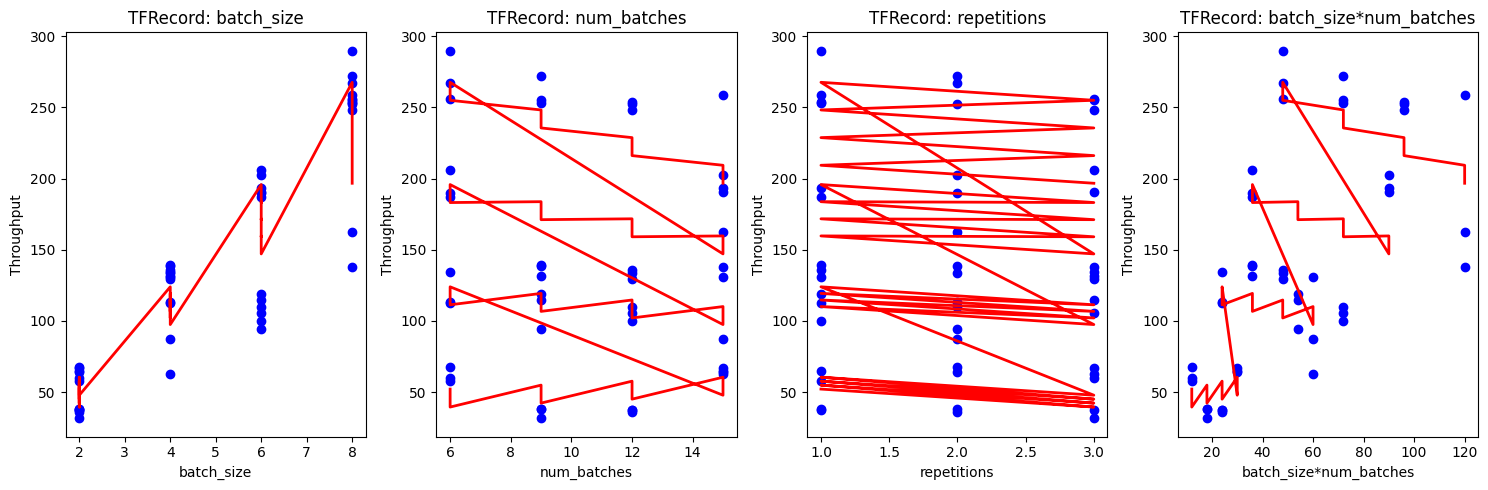

Intercept: -33.582855010889915
Coefficients: [43.28031465  3.3896605  -6.31060232 -1.23251214]
JPEG Regression Results:


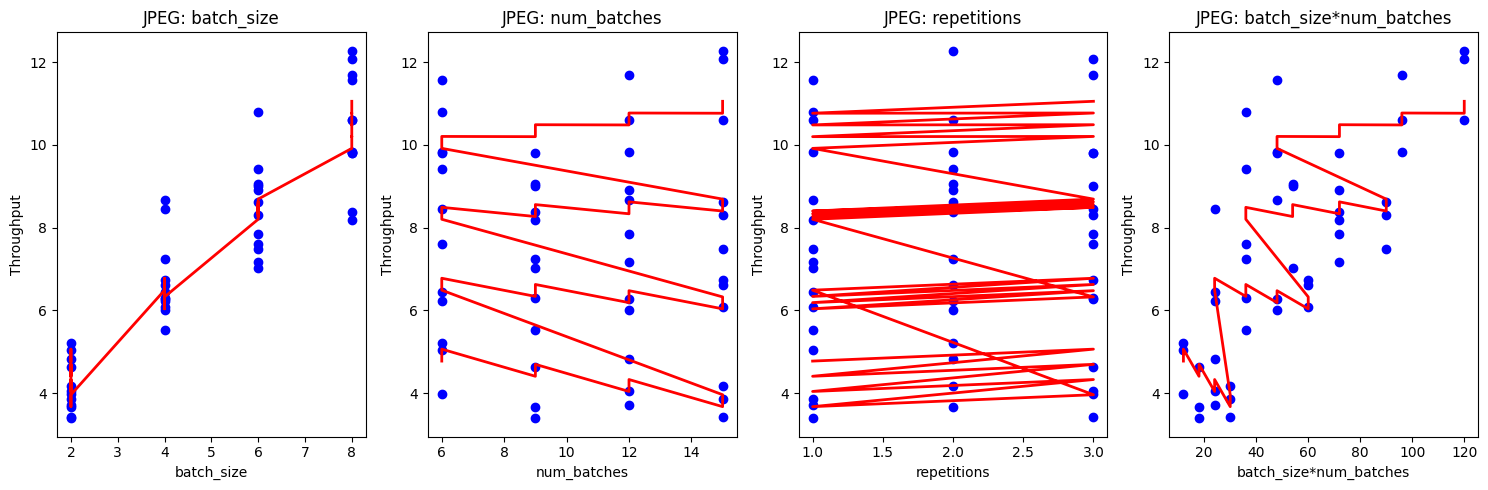

Intercept: 4.085645831426995
Coefficients: [ 0.64016776 -0.19461936  0.14424194  0.03612301]


In [18]:
### CODING TASK ###

# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from pyspark.sql import SparkSession

# Spark session initialisation
spark = SparkSession.builder.appName("Image Processing Analysis").getOrCreate()

# Converting RDD to DataFrame
def rdd_to_df(rdd, schema):
    return spark.createDataFrame(rdd, schema)

# Schema defining for TFRecord & JPEG results
schema = ["params", "throughput"]
tfrecord_df = rdd_to_df(processed_tfrecord_images_rdd, schema)
jpeg_df = rdd_to_df(processed_jpeg_images_rdd, schema)

# Spark to Pandas DataFrame conversion
tfrecord_s_pd = tfrecord_df.toPandas()
jpeg_s_pd = jpeg_df.toPandas()

# Expanding 'batch_size', 'num_batches', 'repetitions' into different columns &
# Adding a new column for product of batch_size and num_batches

# For TFRecords
tfrecord_s_pd[['batch_size', 'num_batches', 'repetitions']] = pd.DataFrame(tfrecord_s_pd['params'].tolist(), index=tfrecord_s_pd.index)
tfrecord_s_pd['batch_size*num_batches'] = tfrecord_s_pd['batch_size'] * tfrecord_s_pd['num_batches']

# For JPEG images
jpeg_s_pd[['batch_size', 'num_batches', 'repetitions']] = pd.DataFrame(jpeg_s_pd['params'].tolist(), index=jpeg_s_pd.index)
jpeg_s_pd['batch_size*num_batches'] = jpeg_s_pd['batch_size'] * jpeg_s_pd['num_batches']

# Regression and plotting of results

def reg_plot(df, title):
    features = ['batch_size', 'num_batches', 'repetitions', 'batch_size*num_batches']
    X = df[features]
    y = df['throughput']

    model = LinearRegression()
    model.fit(X, y)

    # Predicting the values for plotting
    predicted = model.predict(X)

    # Plotting
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(features):
        plt.subplot(1, len(features), i + 1)
        plt.scatter(df[feature], y, color='blue')
        plt.plot(df[feature], predicted, color='red', linewidth=2)
        plt.title(f'{title}: {feature}')
        plt.xlabel(feature)
        plt.ylabel('Throughput')
    plt.tight_layout()
    plt.show()

    return model.intercept_, model.coef_

# Performing regression and plotting for TFRecord and JPEG
print("TFRecord Results for regression:")
tfrecord_intcpt, tfrecord_co = reg_plot(tfrecord_s_pd, "TFRecord")
print("Intercept:", tfrecord_intcpt)
print("Coefficients:", tfrecord_co)

print("JPEG Results for regression:")
jpeg_intcpt, jpeg_co = reg_plot(jpeg_s_pd, "JPEG")
print("Intercept:", jpeg_intcpt)
print("Coefficients:", jpeg_co)

# Section 3. Theoretical discussion

## Task 3: Discussion in context. (24%)

In this task we refer an idea that is introduced in this paper:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given compute task.

### 3a)	Contextualise

Relate the previous tasks and the results to this concept. (It is not necessary to work through the full details of the paper, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply to the task in this coursework? (12%)

### 3b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, stream) and discuss the general relationship with the concepts above. (12%)

Provide the answers to these questions in your report.


## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit.

In [48]:
!gsutil -m rm -r $BUCKET/* # Empty your bucket
!gsutil rb $BUCKET # delete the bucket

Removing gs://earnest-crow-421721-storage/jpeg_results_240504-1038.pickle#1714819092797024...
Removing gs://earnest-crow-421721-storage/avg_tfrecord_speeds.pkl#1714565981655739...
Removing gs://earnest-crow-421721-storage/avg_tfrecord_speeds_240504-2347.pkl#1714866461212171...
Removing gs://earnest-crow-421721-storage/jpeg_results_240504-2257.pickle#1714863468232104...
Removing gs://earnest-crow-421721-storage/avg_tfrecord_speeds_240501-1220.pkl#1714566002873032...
Removing gs://earnest-crow-421721-storage/avg_tfrecord_speeds_240501-1238.pkl#1714567121736339...
Removing gs://earnest-crow-421721-storage/tfrecord_results.pickle#1714920793705811...
Removing gs://earnest-crow-421721-storage/jpeg_results.pickle#1714920794871306...
Removing gs://earnest-crow-421721-storage/jpeg_results_240504-2325.pickle#1714865152067906...
Removing gs://earnest-crow-421721-storage/tfrecord_results_240504-1038.pickle#1714819092346221...
Removing gs://earnest-crow-421721-storage/tfrecord_results_240504-2257.p